In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from datetime import timedelta

# sns.set( style = 'darkgrid' )

# Data Cleaning

In [103]:
df = pd.read_csv( './Sensado_GYM_Completo.csv', encoding = 'ISO-8859-1', parse_dates = [ 'Fecha' ] )
df.columns = [ 'Date', 'Pre', 'Alt', 'Hum', 'Temp', 'Occ' ]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10129 entries, 0 to 10128
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    10129 non-null  datetime64[ns]
 1   Pre     10129 non-null  float64       
 2   Alt     10129 non-null  float64       
 3   Hum     10125 non-null  float64       
 4   Temp    10129 non-null  float64       
 5   Occ     10129 non-null  object        
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 474.9+ KB


## Filling null values

In [104]:
len( df ) - df.count()

Date    0
Pre     0
Alt     0
Hum     4
Temp    0
Occ     0
dtype: int64

In [105]:
df[ 'Hum' ].fillna( method ='ffill', inplace = True )
len( df ) - df.count()

Date    0
Pre     0
Alt     0
Hum     0
Temp    0
Occ     0
dtype: int64

In [106]:
# date format mm-dd-yyyy
# Fixing an error on the dates

temp = df[ ( df.Date >= '2019-01-01' ) & ( df.Date <= '2019-02' ) ][ 'Date' ] + timedelta( days = 264 )
df.loc[ temp.index, 'Date' ] = temp

# Preparing the Datasets

In [107]:
import enum

class DF( enum.Enum ):
    _10SEC = 1
    _REDUCED = 2

AGG = [ 'mean', 'std', pd.DataFrame.kurt ]
# AGG = [ 'mean' ]

dfs = { DF._10SEC: None, DF._REDUCED: None } # holds the dataframes
grids = { 
    'svc': { DF._10SEC: None, DF._REDUCED: None },
    'knn': { DF._10SEC: None, DF._REDUCED: None },
    'dt': { DF._10SEC: None, DF._REDUCED: None } }

# holds the search grids 

## 10 sec. avg. with extra features (std, kurtosis)

In [108]:
def agg_date( col ):
    return col.iloc[ 0 ] # left labeling

def agg_occupancy( col ): 
    return col.mode()[ 0 ]

def groupby_10( g, agg ):
    return g.groupby( np.arange( len( g ) ) // 10 ).agg( { 
        'Date': agg_date, 
        'Occ': agg_occupancy,
        'Pre': agg, 
        'Alt': agg, 
        'Hum': agg, 
        'Temp': agg } )

def rename_col( name ):
    return name[ 0 ] + '_' + name[ 1 ]

temp =  ( df.groupby( df.Date.dt.floor( 'D' ) )
    .apply( groupby_10, AGG )
    .reset_index( drop = True ) )

temp.columns = [ rename_col( c ) for c in temp.columns ]
temp = ( temp
    .rename( columns = { 'Date_agg_date': 'Date', 'Occ_agg_occupancy': 'Occ' } )
    .sort_values( by = 'Date' )
    .reset_index( drop = True ) )

dfs[ DF._10SEC ] = temp.dropna( how = 'any' )
dfs[ DF._10SEC ]

,Date,Occ,Pre_mean,Pre_std,Pre_kurt,Alt_mean,Alt_std,Alt_kurt,Hum_mean,Hum_std,Hum_kurt,Temp_mean,Temp_std,Temp_kurt
0,2019-09-18 19:04:00,M,"95,004.394",1.471,-0.389,540.046,0.130,-0.424,58.536,0.115,-1.599,27.176,0.005,-2.277
1,2019-09-18 19:04:00,M,"95,005.281",2.630,3.415,539.989,0.245,1.310,59.008,0.685,-1.578,27.144,0.048,-0.988
2,2019-09-18 19:04:00,M,"95,005.590",1.250,-0.554,539.935,0.107,0.246,60.226,0.580,-1.949,27.077,0.018,-1.984
3,2019-09-18 19:04:00,M,"95,007.742",1.271,-0.323,539.752,0.112,-0.304,60.301,0.353,-0.689,27.113,0.007,-0.283
4,2019-09-18 19:04:00,M,"95,005.783",1.823,-0.831,539.923,0.159,-0.832,59.250,0.323,-1.622,27.061,0.017,-0.249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1009,2019-10-02 20:48:00,L,"95,188.350",1.786,-0.156,523.924,0.156,-0.154,58.925,0.181,-1.704,27.201,0.006,1.498
1010,2019-10-02 20:48:00,L,"95,200.459",1.283,-0.948,522.864,0.111,-0.971,59.148,0.018,-0.341,27.263,0.005,-1.224
1011,2019-10-02 20:48:00,L,"95,199.183",1.158,0.612,522.974,0.101,0.564,59.220,0.046,0.673,27.270,0.000,0.000
1012,2019-10-02 20:48:00,L,"95,198.701",1.788,-0.068,523.018,0.156,-0.124,58.951,0.094,-0.871,27.250,0.008,-1.393


## 10 sec. avg with reduced features (temp, hum, and pre )

In [109]:
temp =  ( df.groupby( df.Date.dt.floor( 'D' ) )
    .apply( groupby_10, AGG )
    .reset_index( drop = True ) )

temp.columns = [ rename_col( c ) for c in temp.columns ]
temp = ( temp
    .rename( columns = { 'Date_agg_date': 'Date', 'Occ_agg_occupancy': 'Occ' } )
    .reset_index( drop = True )
    .drop( columns = [ 'Temp_std', 'Temp_kurt', 'Hum_std', 'Hum_kurt', 'Pre_std', 'Pre_kurt', 'Alt_std', 'Alt_kurt', 'Alt_mean' ] ) )

dfs[ DF._REDUCED ] = temp.dropna( how = 'any' )
dfs[ DF._REDUCED ]

,Date,Occ,Pre_mean,Hum_mean,Temp_mean
0,2019-09-18 19:04:00,M,"95,004.394",58.536,27.176
1,2019-09-18 19:04:00,M,"95,005.281",59.008,27.144
2,2019-09-18 19:04:00,M,"95,005.590",60.226,27.077
3,2019-09-18 19:04:00,M,"95,007.742",60.301,27.113
4,2019-09-18 19:04:00,M,"95,005.783",59.250,27.061
...,...,...,...,...,...
1010,2019-10-02 20:48:00,L,"95,199.183",59.220,27.270
1011,2019-10-02 20:48:00,L,"95,198.701",58.951,27.250
1012,2019-10-02 20:48:00,L,"95,189.847",59.104,27.270
1013,2019-10-02 20:48:00,L,"95,188.350",58.925,27.201


# Correlation Analysis

In [110]:
pd.options.display.float_format = '{:,.3f}'.format

## Reduced Dataset

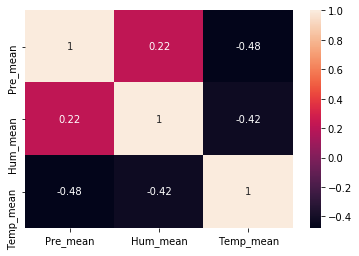

In [111]:
sns.heatmap( dfs[ DF._REDUCED ].corr(), annot = True )

## All featuers dataset

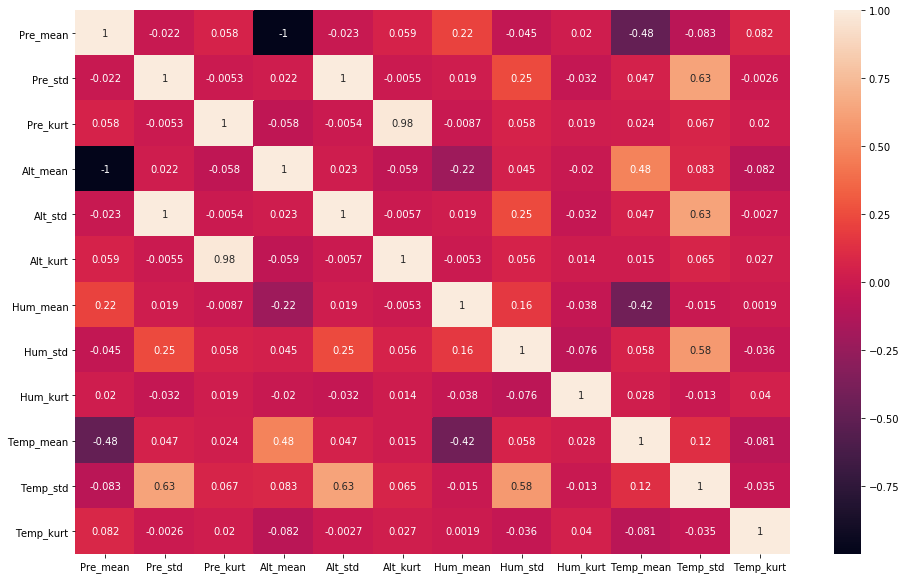

In [112]:
plt.figure( figsize = ( 16, 10 ) )
sns.heatmap( dfs[ DF._10SEC ].corr(), annot = True )

Pressure and altitude presents and strong correlation, suggesting we should remove one of them. 

# Standarization

Pressure have a different magnitud of values than temperature, humidity. Then it is necesary to standarize the dataset before applying any algorithm to prevent pressure from dominating the other features

In [113]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_TRAIN = 0
X_TEST = 1
Y_TRAIN = 2
Y_TEST = 3

def standarize( df ):
    x_train, x_test, y_train, y_test = train_test_split( 
        df.drop( [ 'Occ', 'Date' ], axis = 1 ), 
        df.Occ, 
        test_size = .20, 
        random_state = 0 )
    
    scaler = StandardScaler()
    scaler.fit( x_train )

    x_train = scaler.transform( x_train )
    x_test = scaler.transform( x_test )
    
    return x_train, x_test, y_train, y_test

for k, d in dfs.items() : 
    x_train, x_test, y_train, y_test = standarize( d )
    dfs[ k ] = [ x_train, x_test, y_train, y_test ]

# Classification

In [114]:
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.decomposition import PCA



def grid_search( estimator, params ):
    scoring = 'accuracy'
    cv_method = RepeatedStratifiedKFold( n_splits = 10, n_repeats = 2, random_state = 0 )
    
    return GridSearchCV( 
        estimator = estimator,
        param_grid = params,
        cv = cv_method,
        verbose = False,
        scoring = scoring,
        return_train_score = True )


def train_and_test( estimator, params, x_train, y_train, 
                   x_test, y_test, plot_cmatrix = False ):
    
    grid = grid_search( estimator, params )
    
    # Training and evaluation

    grid.fit( x_train, y_train );
    print( 'Best params: ', grid.best_params_ )
    print( 'Training Accuracy', grid.best_score_ )

    y_pred = grid.best_estimator_.predict( x_test )
    print( 'Test Accuracy: ', accuracy_score( y_test, y_pred ) )
    
    if( plot_cmatrix ) :
        fig, ax = plt.subplots( 1, 1 )
        g = sns.heatmap( confusion_matrix( y_test, y_pred ), annot = True, cmap = "YlGnBu" )
        g.set_title( 'Test Confussion Matrix' )
    
    return grid
    
def add_pca_estimator( estimator ):
    return Pipeline( [ ( 'reduce_dim', PCA( .95 ) ),  ( 'clf', estimator ) ] )
    
def prefix_params( d_list, prefix ):
    result = []
    for d in d_list: 
        temp = {}
        for key in d.keys():
            temp[ prefix + '__' + key ] = d[ key ]
        result.append( temp )
    return result

## SVM

In [117]:
params_svc = [ { 
    'C': [ .1, 1, 10,  ], 
    'kernel': [ 'linear', 'poly' ] 
}, { 
    'C': [ .1, 1, 10 ], 
    'kernel': [ 'rbf' ],
    'gamma': [ 10, 1, 0.1 ]
} ]


print( '-----------------------------------' )
print( 'With different resolutions' )
print( '-----------------------------------' )
for k, df in dfs.items():
    print( 'Dataset ', k )
    train_and_test( 
                svm.SVC(), params_svc, 
                df[ X_TRAIN ], df[ Y_TRAIN ], 
                df[ X_TEST ], df[ Y_TEST ] )
    print()

print( '-----------------------------------' )
print( 'Testing with PCA datasets' )
print( '-----------------------------------' )
for k, df in dfs.items():
    print( 'Dataset ', k )
    grids[ 'svc' ][ k ] = train_and_test( 
                add_pca_estimator( svm.SVC() ), 
                prefix_params( params_svc, 'clf' ), 
                df[ X_TRAIN ], df[ Y_TRAIN ], 
                df[ X_TEST ], df[ Y_TEST ] )
    print()


-----------------------------------
With different resolutions
-----------------------------------
Dataset  DF._10SEC
Best params:  {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Training Accuracy 0.9820987654320987
Test Accuracy:  0.9950738916256158

Dataset  DF._REDUCED
Best params:  {'C': 1, 'gamma': 1, 'kernel': 'rbf'}
Training Accuracy 0.9987729599518218
Test Accuracy:  0.9950738916256158

-----------------------------------
Testing with PCA datasets
-----------------------------------
Dataset  DF._10SEC
Best params:  {'clf__C': 10, 'clf__gamma': 0.1, 'clf__kernel': 'rbf'}
Training Accuracy 0.9814814814814815
Test Accuracy:  0.9950738916256158

Dataset  DF._REDUCED
Best params:  {'clf__C': 1, 'clf__gamma': 1, 'clf__kernel': 'rbf'}
Training Accuracy 0.9987729599518218
Test Accuracy:  0.9950738916256158



## KNN

In [118]:
params_knn = [ { 
    'n_neighbors': [ 1, 3, 8, 13 ], 
    'p': [ 1, 2 ], # mikowsky distance
    'algorithm': [ 'brute', 'ball_tree', 'kd_tree' ]
} ]

print( '-----------------------------------' )
print( 'With different resolutions' )
print( '-----------------------------------' )
for k, df in dfs.items():
    print( 'Dataset ', k )
    train_and_test( KNeighborsClassifier(), params_knn, 
                   df[ X_TRAIN ], df[ Y_TRAIN ], 
                   df[ X_TEST ], df[ Y_TEST ] )
    print()

print( '-----------------------------------' )
print( 'Testing with PCA datasets' )
print( '-----------------------------------' )
for k, df in dfs.items():
    print( 'Dataset ', k )
    grids[ 'knn' ][ k ] = train_and_test( 
                add_pca_estimator( KNeighborsClassifier() ), 
                prefix_params( params_knn, 'clf' ), 
                df[ X_TRAIN ], df[ Y_TRAIN ], 
                df[ X_TEST ], df[ Y_TEST ] )
    print()

-----------------------------------
With different resolutions
-----------------------------------
Dataset  DF._10SEC
Best params:  {'algorithm': 'brute', 'n_neighbors': 8, 'p': 1}
Training Accuracy 0.9783950617283951
Test Accuracy:  0.9802955665024631

Dataset  DF._REDUCED
Best params:  {'algorithm': 'brute', 'n_neighbors': 1, 'p': 1}
Training Accuracy 0.9975383920505871
Test Accuracy:  0.9950738916256158

-----------------------------------
Testing with PCA datasets
-----------------------------------
Dataset  DF._10SEC
Best params:  {'clf__algorithm': 'brute', 'clf__n_neighbors': 13, 'clf__p': 1}
Training Accuracy 0.9574074074074075
Test Accuracy:  0.9458128078817734

Dataset  DF._REDUCED
Best params:  {'clf__algorithm': 'brute', 'clf__n_neighbors': 1, 'clf__p': 1}
Training Accuracy 0.9987729599518218
Test Accuracy:  0.9950738916256158



## Decision Trees

In [120]:
params_dt = [ { 
    'criterion': [ 'gini', 'entropy' ], 
    'max_depth': [ 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12 ]
} ]

print( '-----------------------------------' )
print( 'With different resolutions' )
print( '-----------------------------------' )
for k, df in dfs.items():
    print( 'Dataset ', k )
    train_and_test( DecisionTreeClassifier(), params_dt, 
                   df[ X_TRAIN ], df[ Y_TRAIN ], 
                   df[ X_TEST ], df[ Y_TEST ] )
    print()
    
print( '-----------------------------------' )
print( 'Testing with PCA datasets' )
print( '-----------------------------------' )
for k, df in dfs.items():
    print( 'Dataset ', k )
    grids[ 'dt' ][ k ] = train_and_test( 
        add_pca_estimator( DecisionTreeClassifier() ), 
        prefix_params( params_dt, 'clf' ), 
        df[ X_TRAIN ], df[ Y_TRAIN ], 
        df[ X_TEST ], df[ Y_TEST ] )
    print()

-----------------------------------
With different resolutions
-----------------------------------
Dataset  DF._10SEC
Best params:  {'criterion': 'entropy', 'max_depth': 8}
Training Accuracy 0.9975308641975309
Test Accuracy:  0.9950738916256158

Dataset  DF._REDUCED
Best params:  {'criterion': 'entropy', 'max_depth': 6}
Training Accuracy 0.9975308641975309
Test Accuracy:  0.9950738916256158

-----------------------------------
Testing with PCA datasets
-----------------------------------
Dataset  DF._10SEC
Best params:  {'clf__criterion': 'gini', 'clf__max_depth': 11}
Training Accuracy 0.962962962962963
Test Accuracy:  0.9753694581280788

Dataset  DF._REDUCED
Best params:  {'clf__criterion': 'entropy', 'clf__max_depth': 8}
Training Accuracy 0.9907783800060223
Test Accuracy:  0.9852216748768473



Con los datasets sin PCA, SVM y DT no mostraron diferencia en el accuracy entre el dataset con features extra y el dataset reducido. Por su parte KNN si hubo un incremento utilizando el dataset con features reducidos. Para el escenario donde se aplicó PCA antes de realizar la clasificación, nuevamente SVM no se mostró afectado, sin embargo DT y KNN si mostraron una diferencia positiva en el accuracy usando el dataset con features reducidos. El peor caso fue con KNN, donde se obtuvo una diferencia de 5 puntos porcentuales entre el dataset reducido (0.99) y el el dataset extendido (0.95). En general concluimos que el dataset extendido presenta signos de overfitting ya que en general los features agregados no tuvieron impacto o impactaron negativamente en el performance. 

# Plotting Learning Curves

In [121]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedShuffleSplit

train_sizes, train_scores, valid_scores = learning_curve( 
    grid_pca.best_estimator_, 
    dfs[ DF._10SEC ][ X_TRAIN ], 
    dfs[ DF._10SEC ][ Y_TRAIN ],
    train_sizes = np.linspace( 10, 100, 10, dtype = int ), 
    cv = 5 )

In [122]:
def plot_learning_curve( estimator, title, X, y, axes = None, ylim = None, cv = None,
                        n_jobs = None, train_sizes = np.linspace( .1, 1.0, 5 ) ):

    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim( *ylim )
    axes[0].set_xlabel( 'Training examples' )
    axes[0].set_ylabel( 'Score' )

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve( estimator, X, y, cv = cv, n_jobs = n_jobs,
                       train_sizes = train_sizes,
                       return_times = True )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    
    axes[0].grid()
    axes[0].fill_between( train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha = 0.1,
                         color = 'r')
    axes[0].fill_between( train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha = 0.1,
                         color = 'g' )
    
    axes[0].plot( train_sizes, train_scores_mean, 'o-', color = 'r',
                 label = 'Training score' )
    axes[0].plot( train_sizes, test_scores_mean, 'o-', color = 'g',
                 label = 'Cross-validation score' )
    axes[0].legend( loc = 'best' )

    
    # Plot n_samples vs fit_times
    
    axes[1].grid()
    axes[1].plot( train_sizes, fit_times_mean, 'o-' )
    axes[1].fill_between( train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha = 0.1 )
    axes[1].set_xlabel( 'Training examples' )
    axes[1].set_ylabel( 'fit_times' )
    axes[1].set_title( 'Scalability of the model' )
    
    
    # Plot fit_time vs score
    
    axes[2].grid()
    axes[2].plot( fit_times_mean, test_scores_mean, 'o-' )
    axes[2].fill_between( fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha = 0.1 )
    axes[2].set_xlabel( 'fit_times' )
    axes[2].set_ylabel( 'Performance of the model' )
    axes[2].set_title( 'Performance of the model' )

    return plt

## SVM

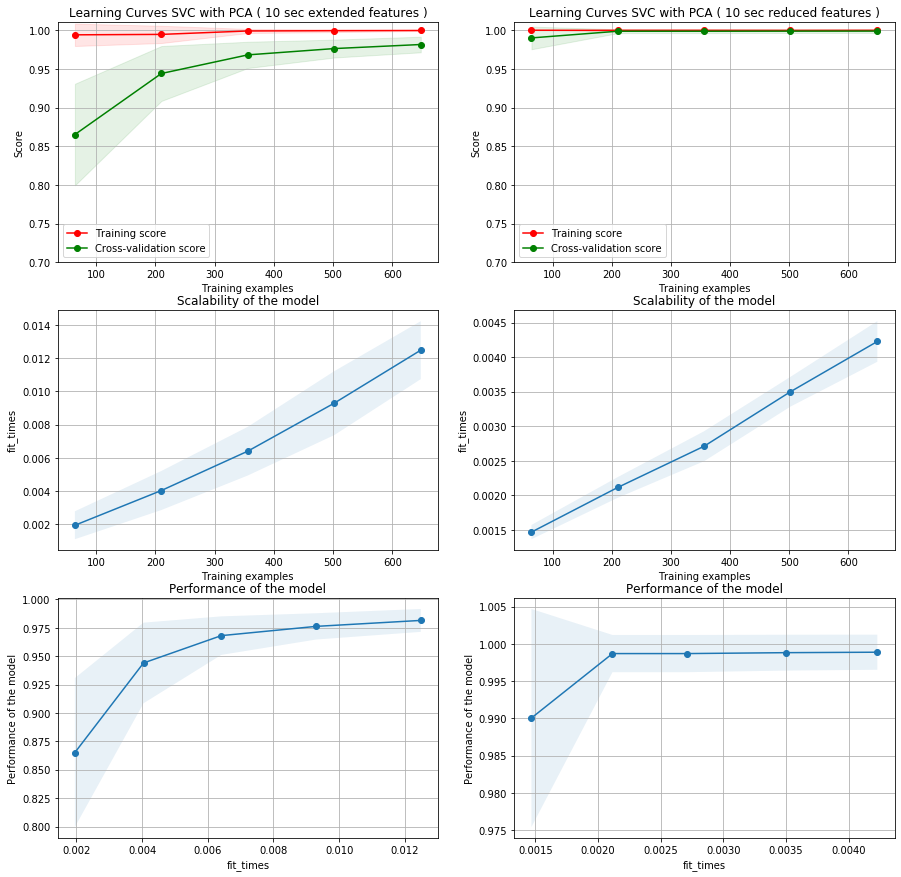

In [124]:
fig, axes = plt.subplots( 3, 2, figsize=( 15, 15 ) )

# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.

cv = StratifiedShuffleSplit( n_splits = 100, test_size = 0.2, random_state = 0 )
title = 'Learning Curves SVC with PCA ( 10 sec extended features )'
plot_learning_curve( grids[ 'svc' ][ DF._10SEC ].best_estimator_, 
                    title, 
                    dfs[ DF._10SEC ][ X_TRAIN ], 
                    dfs[ DF._10SEC ][ Y_TRAIN ], 
                    axes = axes[ :, 0 ], 
                    ylim = ( 0.7, 1.01 ),
                    cv = cv, 
                    n_jobs = 4 )

cv = StratifiedShuffleSplit( n_splits = 100, test_size = 0.2, random_state = 0 )
title = 'Learning Curves SVC with PCA ( 10 sec reduced features )'
plot_learning_curve( grids[ 'svc' ][ DF._REDUCED ].best_estimator_, 
                    title, 
                    dfs[ DF._REDUCED ][ X_TRAIN ], 
                    dfs[ DF._REDUCED ][ Y_TRAIN ], 
                    axes = axes[ :, 1 ], 
                    ylim = ( 0.7, 1.01 ),
                    cv = cv, 
                    n_jobs = 4 )

plt.show()

## KNN

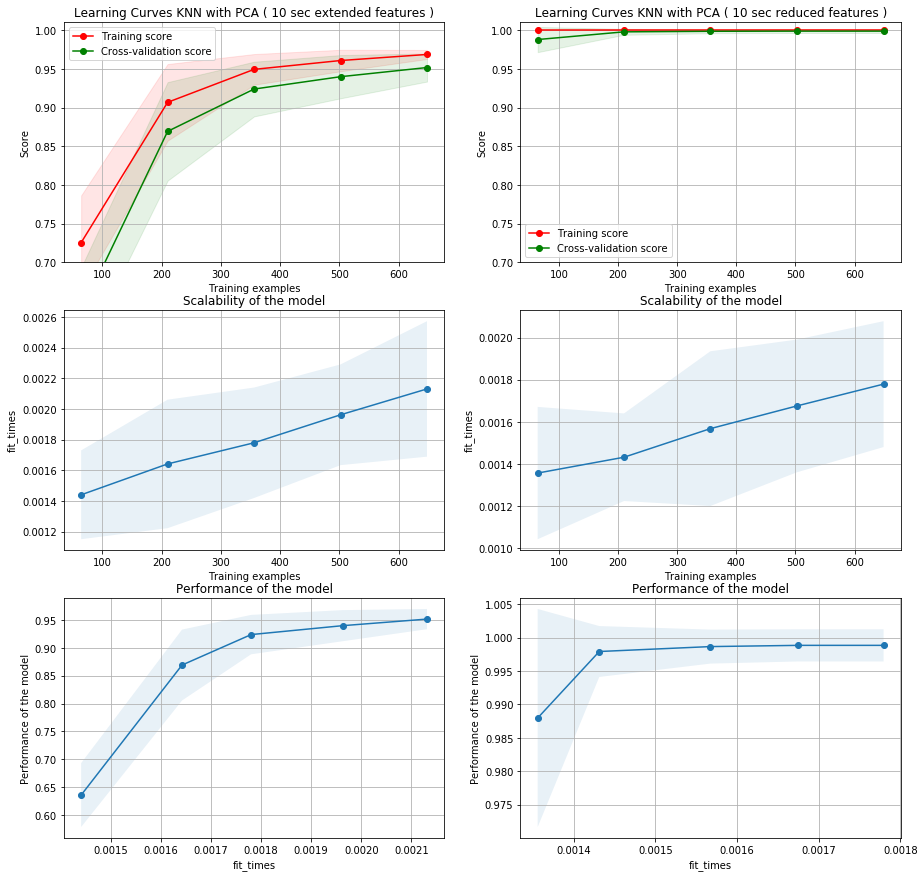

In [125]:
fig, axes = plt.subplots( 3, 2, figsize=( 15, 15 ) )

cv = StratifiedShuffleSplit( n_splits = 100, test_size = 0.2, random_state = 0 )
title = 'Learning Curves KNN with PCA ( 10 sec extended features )'
plot_learning_curve( grids[ 'knn' ][ DF._10SEC ].best_estimator_, 
                    title, 
                    dfs[ DF._10SEC ][ X_TRAIN ], 
                    dfs[ DF._10SEC ][ Y_TRAIN ], 
                    axes = axes[ :, 0 ], 
                    ylim = ( 0.7, 1.01 ),
                    cv = cv, 
                    n_jobs = 4 )

cv = StratifiedShuffleSplit( n_splits = 100, test_size = 0.2, random_state = 0 )
title = 'Learning Curves KNN with PCA ( 10 sec reduced features )'
plot_learning_curve( grids[ 'knn' ][ DF._REDUCED ].best_estimator_, 
                    title, 
                    dfs[ DF._REDUCED ][ X_TRAIN ], 
                    dfs[ DF._REDUCED ][ Y_TRAIN ], 
                    axes = axes[ :, 1 ], 
                    ylim = ( 0.7, 1.01 ),
                    cv = cv, 
                    n_jobs = 4 )

plt.show()

## DT

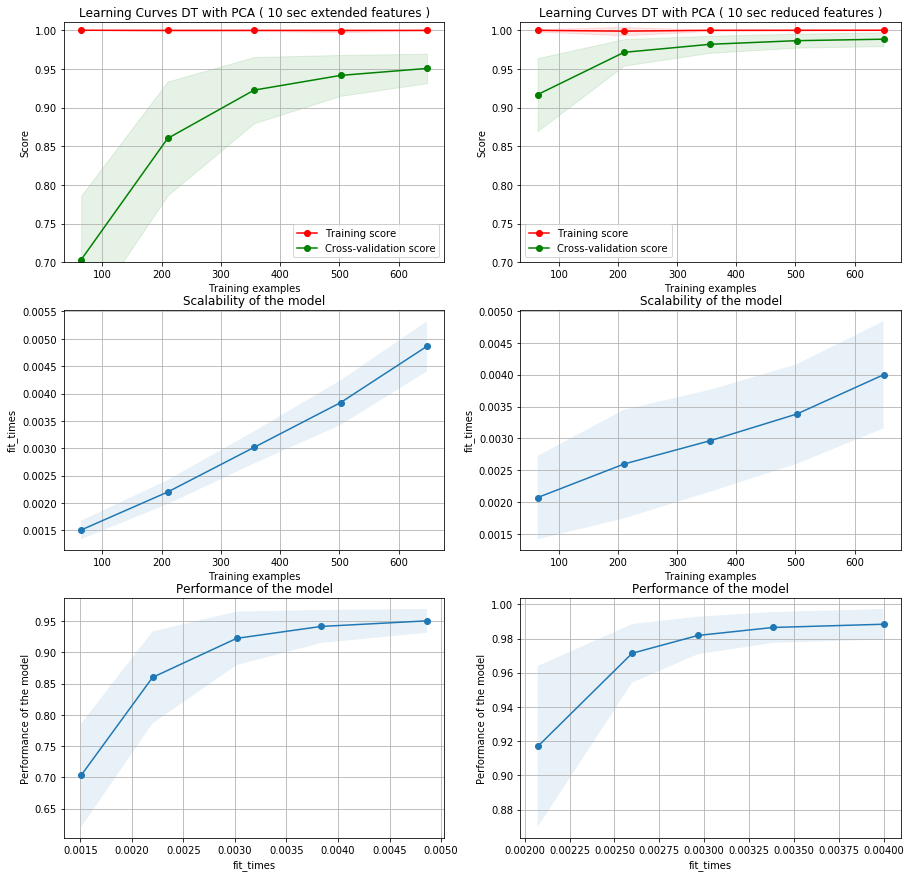

In [126]:
fig, axes = plt.subplots( 3, 2, figsize=( 15, 15 ) )

cv = StratifiedShuffleSplit( n_splits = 100, test_size = 0.2, random_state = 0 )
title = 'Learning Curves DT with PCA ( 10 sec extended features )'
plot_learning_curve( grids[ 'dt' ][ DF._10SEC ].best_estimator_, 
                    title, 
                    dfs[ DF._10SEC ][ X_TRAIN ], 
                    dfs[ DF._10SEC ][ Y_TRAIN ], 
                    axes = axes[ :, 0 ], 
                    ylim = ( 0.7, 1.01 ),
                    cv = cv, 
                    n_jobs = 4 )

cv = StratifiedShuffleSplit( n_splits = 100, test_size = 0.2, random_state = 0 )
title = 'Learning Curves DT with PCA ( 10 sec reduced features )'
plot_learning_curve( grids[ 'dt' ][ DF._REDUCED ].best_estimator_, 
                    title, 
                    dfs[ DF._REDUCED ][ X_TRAIN ], 
                    dfs[ DF._REDUCED ][ Y_TRAIN ], 
                    axes = axes[ :, 1 ], 
                    ylim = ( 0.7, 1.01 ),
                    cv = cv, 
                    n_jobs = 4 )

plt.show()